In [1]:
import numpy as np

## Defining the generic metrics class

In [2]:
class GeneralModelClass:
    # Where k∗ is the numbers of parameters you're estimating INCLUDING an intercept. 
    #(The residual vector will exist in an n−k∗ dimensional linear space.)

    # If you include an intercept term in a regression and k refers to the number of regressors
    # not including the intercept then k∗=k+1.
         
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.predict(self.data) - self.target)**2# using target, predict and data, find the squared errors
        self.sq_error_ = sum(squared_errors)# find the Sum of squared errors
        return self.sq_error_
        
    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        self.sst_ = np.sum(squared_errors)
        return self.sst_
    
    def r_squared(self):
        '''returns calculated value of r^2'''
        self.r_sq_ = 1 - (self.sse()/self.sst()) # using SST and SSE, find the R-squared value
        return self.r_sq_
    
    def adj_r_squared(self):
        '''returns calculated value of adjusted r^2'''
        self.adj_r_sq_ = 1 - (self.sse()/self._dfe) / (self.sst()/self._dft)
        return self.adj_r_sq_
    
    def rmse(self):
        '''returns calculated value of mse'''
        # using predict, data and target, find the RMSE error
        self.rmse_ = np.sqrt(sum((self.predict(self.data) - self.target)**2)/len(self.data)) # your code
        return self.rmse_
    
    def pretty_print_stats(self):
        '''returns report of statistics for a given model object'''
        items = ( ('rmse:', self.rmse()), ('r^2:', self.r_squared()), 
                  ('adj_r^2:', self.adj_r_squared()))
        for item in items:
            print('{0:8} {1:.4f}'.format(item[0], item[1]))


## Defining the Linear Regression Class

In [3]:
# only makes sense for Linear Regression https://stats.stackexchange.com/questions/23128/solving-for-regression-parameters-in-closed-form-vs-gradient-descent
class LinearRegressionOwn(GeneralModelClass):
    
    
    def __init__(self, fit_intercept=True):
        self.coef_ = None
        self.intercept_ = None
        self._fit_intercept = fit_intercept
          
        
    def fit(self, X, y):
        """
        Fit model coefficients.

        Arguments:
        X: 1D or 2D numpy array 
        y: 1D numpy array
        """
         #degrees of freedom population dep. variable variance -- this is total amount of degrees
        self._dft = X.shape[0] - 1   
        # degrees of freedom for the residuals
        self._dfe = X.shape[0] - X.shape[1] - 1  # the more independent variables, the less adj_R-sq
        
        # training data & ground truth data
        self.data = X
        self.target = y
                
        # check if X is 1D or 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1,1)
            
        # add bias if fit_intercept
        if self._fit_intercept:
            X = np.c_[np.ones(len(X)), X]# add the bias term inside here
        
        # closed form solution
        xTx = np.dot(X.T, X)# using X transposed and X matrices, find the data covariance matrix (X.T ?operator? X)
        inverse_xTx = np.linalg.inv(xTx) # find the inverse of the cov matrix, i.e. the precision matrix
        xTy = np.dot(X.T, y)# find X.transposed times y using ?what? operator
        coef = np.dot(inverse_xTx, xTy)
        
        # set attributes
        if self._fit_intercept:
            self.intercept_ = coef[0] # set the 0th coefficient as the intercept
            self.coef_ = coef[1:]# the remaining coefficients go here
        else:
            self.intercept_ = 0 # otherwise set intercept to be 0
            self.coef_ = coef
            
    def predict(self, X):
        """Output model prediction.

        Arguments:
        X: 1D or 2D numpy array 
        """
        # check if X is 1D or 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1,1)  # force 1D array into a column vector
        return (self.intercept_ + np.dot(X, self.coef_)) #using intercept, coefficients and X and linear regression formula, find the predictions
    
    def __str__(self):
        return "Results: b: {}, m: {}, Final Total error: {}".format(round(self.b, 2), round(self.m, 2), round(self.compute_error(), 2))

## The Problem : Housing Price Prediction

In [4]:
from sklearn.datasets import load_boston
import pandas as pd
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### What is in the Dataset?

In [5]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
boston.isna().sum() # find the sum of null values for each variable

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Visualizing  The Dependent Variable

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(boston['CRIM'], kde=True,hist=True, bins=30);# visualize the distribution of the dependent variable (KDE + 30-bin histogram)

## Selecting Features Based on Correlation

          B  CHAS      CRIM  INDUS  LSTAT  PTRATIO   RAD     RM    ZN
0    396.90   0.0   0.00632   2.31   4.98     15.3   1.0  6.575  18.0
1    396.90   0.0   0.02731   7.07   9.14     17.8   2.0  6.421   0.0
2    392.83   0.0   0.02729   7.07   4.03     17.8   2.0  7.185   0.0
3    394.63   0.0   0.03237   2.18   2.94     18.7   3.0  6.998   0.0
4    396.90   0.0   0.06905   2.18   5.33     18.7   3.0  7.147   0.0
5    394.12   0.0   0.02985   2.18   5.21     18.7   3.0  6.430   0.0
6    395.60   0.0   0.08829   7.87  12.43     15.2   5.0  6.012  12.5
7    396.90   0.0   0.14455   7.87  19.15     15.2   5.0  6.172  12.5
8    386.63   0.0   0.21124   7.87  29.93     15.2   5.0  5.631  12.5
9    386.71   0.0   0.17004   7.87  17.10     15.2   5.0  6.004  12.5
10   392.52   0.0   0.22489   7.87  20.45     15.2   5.0  6.377  12.5
11   396.90   0.0   0.11747   7.87  13.27     15.2   5.0  6.009  12.5
12   390.50   0.0   0.09378   7.87  15.71     15.2   5.0  5.889  12.5
13   396.90   0.0   

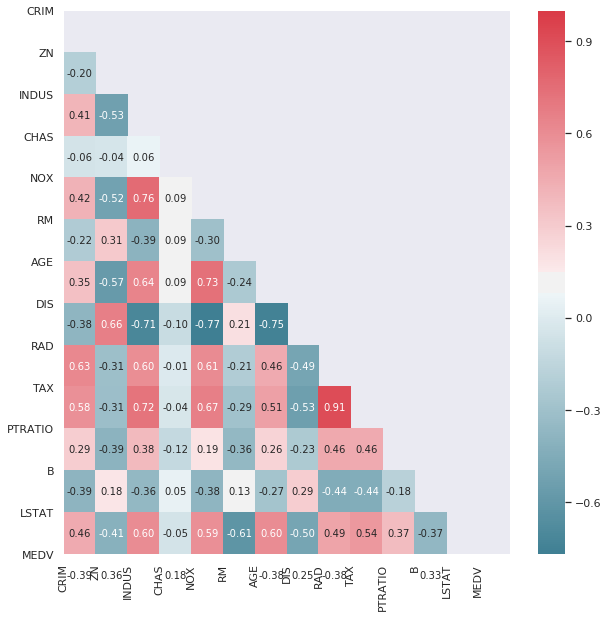

In [8]:
def doCorrelationReduction(corr_matrix = boston.corr(), original_data = boston, corr_thr=0.7):
    """Method to  select only the data with features that have low correlations between themselves"""
    import numpy as np
    corr_matrix_abs = corr_matrix.abs()
    upper = corr_matrix_abs.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))  # # Select upper triangle of correlation matrix
    # # Find index of feature columns with correlation greater than threshold
    #to_drop = [i for i in corr_matrix_abs.loc if(corr_matrix_abs.loc[corr_matrix_abs[i]].idxmax() > corr_thr)]     
    to_drop = [i for i in upper.columns if(upper[i].max()>corr_thr)]

    # [inside the list, using upper.columns, select any column (name) that has higher correlation than corr_thr value]
    low_cor_data = boston[boston.columns.difference(to_drop)]
    # using the difference operator on the original data dataframe columns, subtract the to_drop columns
    
    return low_cor_data

def heatMap(df, mirror=False):

   # Create Correlation df
   corr = df.corr()
   # Plot figsize
   fig, ax = plt.subplots(figsize=(10, 10))
   # Generate Color Map
   colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
   if mirror == True:
      #Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
      #Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      #Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
      #show plot

   else:
      # Drop self-correlations
      dropSelf = np.zeros_like(corr)
      dropSelf[np.triu_indices_from(dropSelf)] = True
      # Generate Color Map
      colormap = sns.diverging_palette(220, 10, as_cmap=True)
      # Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
      # Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      # Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
   # show plot
   plt.show()

print(doCorrelationReduction())
heatMap(df=boston)
boston_corr_reduced = doCorrelationReduction()

### Notice Any Dimensionality Reduction?

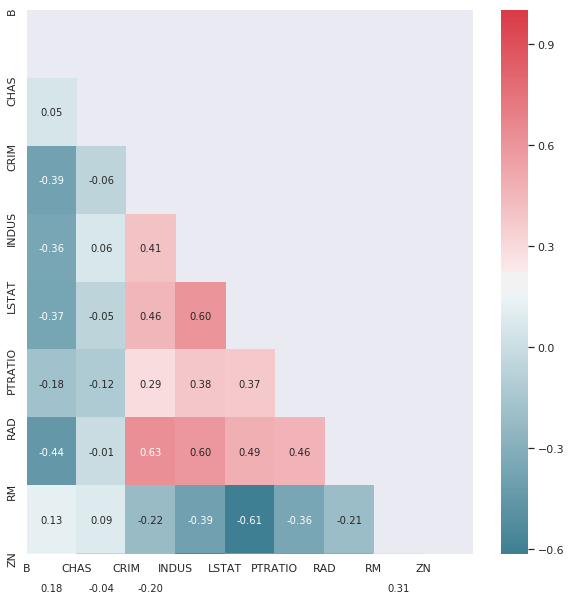

In [9]:
heatMap(df=boston_corr_reduced)
#boston_corr_reduced.head()

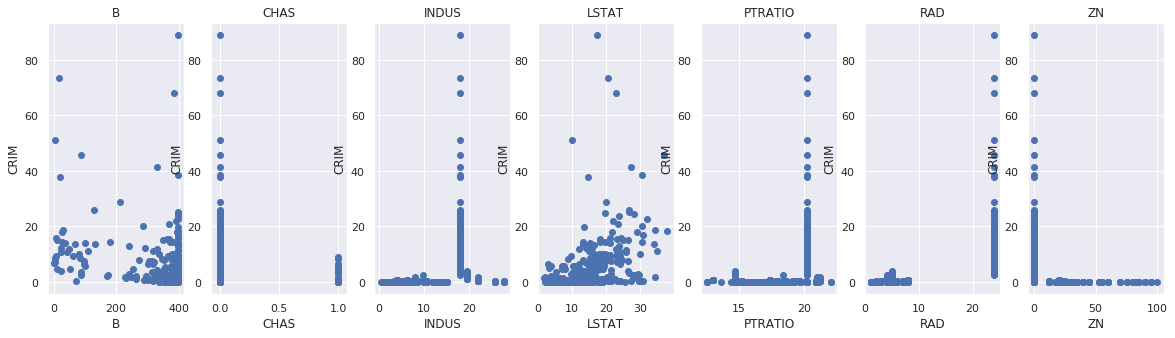

In [10]:
plt.figure(figsize=(20, 5))

features = ['B', 'CHAS', 'INDUS', 'LSTAT', 'PTRATIO', 'RAD', 'ZN']
target = boston['CRIM']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('CRIM')

## Preparing Data for Machine Learning

In [11]:
X = pd.DataFrame(np.c_[boston['LSTAT'], boston['RM']], columns = ['LSTAT','RM'])
Y = boston['CRIM']
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 2)
(102, 2)
(404,)
(102,)


In [12]:
# importlib.reload(mymodule), # https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
general_model = GeneralModelClass()
linreg_model = LinearRegression(general_model)
linreg_model.__dict__
linreg_model.fit(X=X_train,y=Y_train)
linreg_model.pretty_print_stats()

NameError: name 'LinearRegression' is not defined

In [ ]:
import inspect
lines = inspect.getsource(linreg_model.pretty_print_stats)
print(lines)

## Points to remember:

**make sure if you add features that you transform both train and test when you transform your data**


You can implement linear regression in Python relatively easily by using the package statsmodels as well. Typically, this is desirable when there is a need for more detailed results.

In [ ]:
import statsmodels.api as sm
X_constant_added = sm.add_constant(X)
model = sm.OLS(y, exog=X_constant_added)
results_statsmodel = model.fit()
print(results_statsmodel.summary())
print('coefficient of determination:', results_statsmodel.rsquared)
print('adjusted coefficient of determination:', results_statsmodel.rsquared_adj)
print('regression coefficients:', results_statsmodel.params)

## Task : Multiple Regression Comparison with 3 Different Libraries

In this task, your task is to predict the crime rate in Boston, using multiple different features.
**Split the Boston housing dataset into training and test sets using Scikit-learn train-test split function.**

- 0.0 Are the features linearly independent of each other? Show this programmatically.
- 0.1 Are the assumptions for linear regression fulfilled?

(https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0


In the next steps, we will look at some concrete models. **Remember to measure both the training and prediction times of your runs.**

- 1.0 Define a multiple linear regression model in Scikit-Learn with all features
- 1.1 Define a multiple linear regression model in Scikit-Learn with low correlated features


- 3.0 Define a multiple linear regression model in statsmodels with all features
- 3.1  Define a multiple linear regression model in statsmodels with low correlated features




- 5. Remember that the training error is not a good metric for evaluation how well a model generalizes. That's why you should now compare the results by MSE achieved on the test set. 

- Which model generalizes the best?
- Did you see any significant improvement in generalization by eliminating features that are highly correlated to others?
- Was there any considerable speed differences between the runtimes of the model? Did you use GPU or not?



### BONUS POINT QUESTIONS (+1.5 %):

- 2.0 Define a multiple polynomial regression model in Scikit-Learn with all features
- 2.1 Define a multiple polynomial regression model in Scikit-Learn with low correlated features

- 4.0 Define a multiple linear regression model in Pytorch with all features
- 4.1 Define a multiple linear regression model in Pytorch with low correlated features

- Use Bayesian Feature Selection (refer to the appropriate method in SkLearn or Lasso to Select the best performing features).

*Include the analysis points given before also for these models.*

In [ ]:
y = boston['CRIM']
X = boston.drop('CRIM', axis=1)
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y)
X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

In [ ]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(lin_reg, y)  

***Question 0.0 - 0.1***

Q: Are the features linearly independent of each other? Show this programmatically.

A: No, and we can see this based on our graphs.

Q: Are the assumptions for linear regression fulfilled?

A: No, a linear regression model would have high bias.

In [ ]:
y = boston['CRIM']
X = boston.drop('CRIM', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(regressor.intercept_)
print(regressor.coef_)

In [ ]:
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

***Questions 1.0 - 1.1***

Define a multiple linear regression model in Scikit-Learn with all features

Define a multiple linear regression model in Scikit-Learn with low correlated features

In [ ]:
y = boston['CRIM']
X = boston.copy()

y.groupby(X.CHAS).mean()

In [ ]:
import statsmodels.formula.api as smf
# encode df.famhist as a numeric via pd.Factor
est = smf.ols(formula="CRIM ~ CHAS", data=X).fit()

In [ ]:
from IPython.core.display import HTML
def short_summary(est):
    return HTML(est.summary().tables[1].as_html())
# fit OLS on categorical variables children and occupation
est = smf.ols(formula='CRIM ~ C(CHAS)', data=X).fit()
#short_summary(est)
est.summary()

***Question 3.0 - 3.1***

Define a multiple linear regression model in statsmodels with all features

Define a multiple linear regression model in statsmodels with low correlated features

In [ ]:
y = boston_corr_reduced['CRIM']
X = boston_corr_reduced.copy()

y.groupby(X.CHAS).mean()
est = smf.ols(formula="CRIM ~ CHAS", data=X).fit()
short_summary(est)

In [ ]:
est.summary()

In [ ]:
linreg_model.pretty_print_stats()

***Question 5.*** 

Remember that the training error is not a good metric for evaluation how well a model generalizes. That's why you should now compare the results by MSE achieved on the test set. 

- Which model generalizes the best?
- Did you see any significant improvement in generalization by eliminating features that are highly correlated to others?
- Was there any considerable speed differences between the runtimes of the model? Did you use GPU or not?

The sklearn model is slightly better at fitting a linear model to our data set. With that said, after looking at the distribution of our data, I would not fit this data to a linear model as this would introduce a very high bias and ultimately have a very high error rate.

No, this had little to no impact.

No, the runtime for both was around 15s.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

y = boston['CRIM']
X = boston.drop('CRIM', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

linreg_model = LinearRegressionOwn().fit(X, y)
linreg_model_sklearn = LinearRegression().fit(X, y)
transformer = PolynomialFeatures(degree=2, include_bias=False)
X_with_polynomial =  transformer.fit_transform(X)

In [ ]:
## Comparison of Predictions
y_pred_own = linreg_model.predict(X_test)
y_pred_sklearn = linreg_model_sklearn.predict(X_test)

y_pred_sklearn

In [ ]:
y_pred_sklearn